## Using Twitter for Disaster Alerts 

## Problem Statement
Smartphones are owned by almost anyone these days which has in turn caused an explosive rise in use of social media over the past few decades. People are constantly communicating their opinions on current events, personal life occurences, internet memes, and observations in the real world. This constant stream of information while diversionary and insightful to human minds are often most peoples primary source of important alerts in the happenings of the world. Twitter for example, is a vast and constantly updating source of information and method of communication that has been avoided as a source of information due to scraping and readability issues based off the way that people typically type. Howevere, with advances in NLP processing and modelling, social media can be used to read tweets and even understand whether a person is tweeting about normal non disaster related events, or emergencies that can be used to generate and put out alerts. This project will show that social media is a valid source of information even with simple modelling techniques. 

**Table of Contents**
1. [Imports](#Imports)
2. [Data Used](#Data-Used)
3. [Tweet Cleaning and Preprocessing](#Tweet-Cleaning-and-Preprocessing)
4. [EDA](#EDA)
5. [Modeling and Validation](#Modeling-and-Validation)
    - [Baseline Models](#Baseline-Models)
    - [Modelling and Gridsearch](#Modelling-Gridsearch)
    - [Gridsearch and Validation Function](#Gridsearch-and-Validation-Function)
6. [Conclusions and Next Steps](#Conclusions-and-Next-Steps)

### Imports

In [1]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# imports for tweet cleaning
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# imports for modeling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score
import warnings

##### Data Used

Data was taken from the [Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/data) kaggle competition where 10,000 tweets were hand classified between tweets pertinent to disasters and tweets not disaster related. The `train.csv` file will be used to train the models in this notebook and validate the final model using a train/test split.

In [2]:
df = pd.read_csv('./data/train.csv')

In [3]:
df.shape

(7613, 5)

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Tweet Cleaning, and Preprocessing

First the classifer variable and the variable representing the corpus of tweets are defined. 

In [5]:
# Set up classifier output variable
y = df['target']

# Setting up corpus by first removing all website links from tweets
X = df['text'].str.replace('http\S+|www.\S+', ' ', case = False)

Within the set up of the corpus, `X` variable, I have already cleaned the tweets of any sort of text that resembles a website link. This will leave the tweets with hashtags, numbers, and mixed cases but the text will be readable by human eyes so as to be able to read through tweets and verify the classification indicated in the `target` column per tweet.<br>  

The following function will clean the tweets further by removing non-letters, stopwords, and lowercasing all letters in the tweet. The function will also give me the option to lemmatize or stem the remaining words in the tweets. 

In [6]:
def tweet_cleaning(raw, lemmat = False, stem = False):
    # 1. Remove non-letters.
    letters_only = re.sub('[^a-zA-Z]', ' ', raw)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. Join all the stopwords as a string with " ", remove "'" from the stopwords and split it as a list.
    stops = " ".join(stopwords.words('english')).replace("'", "").split()
    
    # 4. Remove stopwords.
    meaningful_words = [w for w in words if not w in stops]
    
    # lemmatizing corpus
    if lemmat == True and stem == False:
        lemmatizer = WordNetLemmatizer()
        lemmatizing = [lemmatizer.lemmatize(word) for word in meaningful_words]
        return(" ".join(lemmatizing))
    # Stemming corpus
    elif lemmat == False and stem == True:
        p_stemmer = PorterStemmer()
        stemming = [p_stemmer.stem(word) for word in meaningful_words]
        return(" ".join(stemming))
    # Simple cleaning of corpus
    else:
        return(" ".join(meaningful_words))

Stemming the corpus loses the contextual interpretability that might be necessary for visualization when it comes to choosing which words to use in the modeling process. This is evident in the stemmed corpus below where words like "earthquake", "wildfire" and "evacuation" are shortened down to "earthquak" and "wildfir" and "evacu". In the case of "earthquake" and "wildfire" it is still relativelly easy to guess what the original word was but with a stemmed word like "evacu", the original word could have been "evacuation", "evacuate", "evacuating", and so on. When using data such as a tweet, where slang and subtly mispelled words can change the meaning of a tweet, it is important to retain as much of the properly spelled words as possible for the sake of interpretibility of the model when classifying between a disaster and non disaster related tweet.

In [7]:
X_stem = df['text'].str.replace('http\S+|www.\S+', ' ', case = False).copy()
X_stem = X_stem.apply(lambda tweet: tweet_cleaning(tweet, stem = True))

In [8]:
X_stem.head()

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3          peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
Name: text, dtype: object

In order to maintain the readability of the tweets, the lemmatizer will be used instead of the stemmer.

In [10]:
X = X.apply(lambda tweet: tweet_cleaning(tweet, lemmat = True))

In [11]:
X.head()

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3    people receive wildfire evacuation order calif...
4    got sent photo ruby alaska smoke wildfire pour...
Name: text, dtype: object

### EDA

With general text cleaning and processing done, I checked the classification balance of the tweets. While the negative class (non-disaster related tweets) is larger, there is not a significance class imbalance that will require oversampling. However, an adaboost model may be useful to run later for validation purposes just in case.  

0    0.57034
1    0.42966
Name: target, dtype: float64

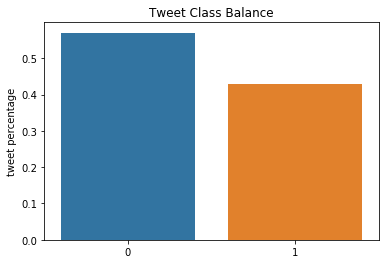

In [13]:
class_balance = y.value_counts(normalize = True)
sns.barplot(class_balance.index, class_balance)
plt.gca().set_ylabel('tweet percentage')
plt.gca().set_title('Tweet Class Balance')
class_balance

The corpus will be processed through a CountVectorizer and a TfidfVectorizer in order to run classification models based off the term frequency as well as the term frequency inverse document frequency of all words in the corpus. The CountVectorizer will model based purely on how often a word appears in the corpus but the TfidfVectorizer will take into account the number of times a word appears in a tweet but also the number of tweets that a word apears in. This will be more useful in the classification model because it will essentially rank a word based off its contextual importance. Words that are high in occurence such as "like" or "the" will show higher weight in the model in a count vectorized training set. However, a tfidf vectorized training set will rank words by term frequency but put higher weight on words with lower document frequency on the assumption that those words will have higher contextual importance. Both the CountVectorizer and the TfidfVectorizer will be used for comparison. 

In [14]:
#Instantiate Vectorizers
cvec = CountVectorizer()
tfidf = TfidfVectorizer()

# Train/Test Split
X_train,X_test, y_train, y_test = train_test_split(X, y, 
                                                   stratify = y, # maintains the class balance 
                                                   random_state = 42)

In [16]:
# Count Vectorized Corpus
X_cvec = pd.DataFrame(cvec.fit_transform(X).toarray(),
                      columns = cvec.get_feature_names())

# TfidfVectorized Corpus
X_tfidf = pd.DataFrame(tfidf.fit_transform(X).toarray(),
                       columns = tfidf.get_feature_names())

# CountVectorized train/test split
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).toarray(), 
                       columns = cvec.get_feature_names())
X_test_cvec = pd.DataFrame(cvec.transform(X_test).toarray(),
                      columns = cvec.get_feature_names())

# TfidfVectorized train/test split
X_train_tfidf = pd.DataFrame(tfidf.fit_transform(X_train).toarray(), 
                       columns = tfidf.get_feature_names())
X_test_tfidf = pd.DataFrame(tfidf.transform(X_test).toarray(),
                      columns = tfidf.get_feature_names())

In [17]:
X_train_cvec.head()

,aa,aaaaaaallll,aaaaaand,aaarrrgghhh,aace,aal,aan,aannnnd,aar,aaronthefm,...,zojadelin,zombie,zone,zoom,zouma,zourryart,zrnf,zumiez,zurich,zxathetis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X_train_tfidf.head()

,aa,aaaaaaallll,aaaaaand,aaarrrgghhh,aace,aal,aan,aannnnd,aar,aaronthefm,...,zojadelin,zombie,zone,zoom,zouma,zourryart,zrnf,zumiez,zurich,zxathetis
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Comparison of Top Words using TfidfVectorizer and CountVectorizer**<br>

Below you can see the top 10 most influential words models will be using to classify the tweets using both the count and tfidf vectorizer methods. Both methods have recognized the importance of words such as "fire" and "disaster" in the disaster related tweets. However, the CountVectorizer will rank "via", a word which can be used in a number of contexts not related to disaster classification, as the 5th most important word in a model simply because it occurs more frequently. The TfidfVectorizer is clearly able to realize that while "via" may be an important word in the corpus, it is not nearly as important because it does not show up as frequently in disaster related tweets and therefore ranks the word lower using the tfidf metric. This shows that a model using a tfidf vectorized corpus may perform better than a model using a count vectorized corpus. This will be evident in the validation scores used later on. 

In [19]:
tfidf_vis= pd.merge(X_tfidf,df['target'], left_index= True, right_index= True)
cvec_vis = pd.merge(X_cvec, df['target'], left_index= True, right_index = True)

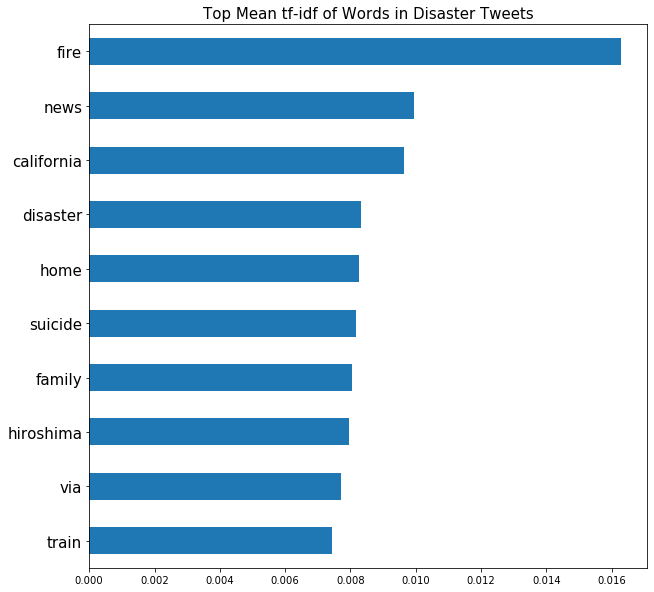

In [20]:
tfidf_vis.loc[tfidf_vis['target_y']==1].drop(columns = 'target_y').mean().sort_values(ascending= True).tail(10).plot(kind = 'barh', figsize = (10,10));
plt.yticks(fontsize = 15);
plt.xticks(fontsize = 10);
plt.title('Top Mean tf-idf of Words in Disaster Tweets', fontsize = 15);

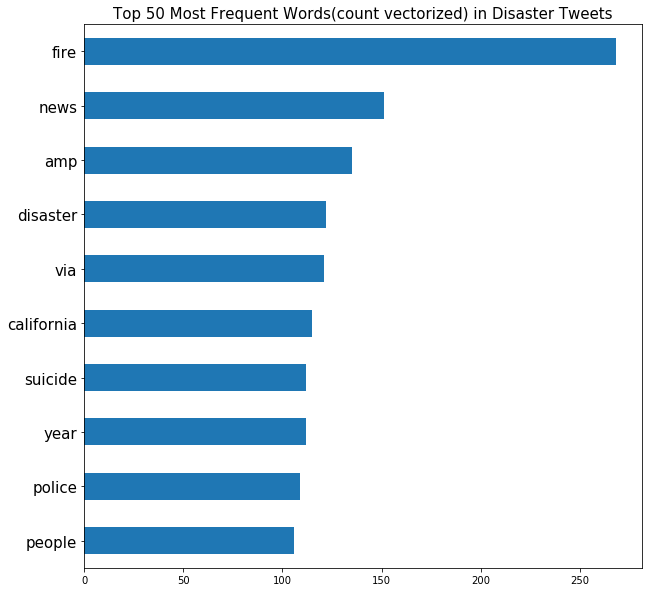

In [21]:
cvec_vis.loc[cvec_vis['target_y']==1].drop(columns = 'target_y').sum().sort_values(ascending= True).tail(10).plot(kind = 'barh', figsize = (10,10));
plt.yticks(fontsize = 15);
plt.xticks(fontsize = 10);
plt.title('Top 50 Most Frequent Words(count vectorized) in Disaster Tweets', fontsize = 15);

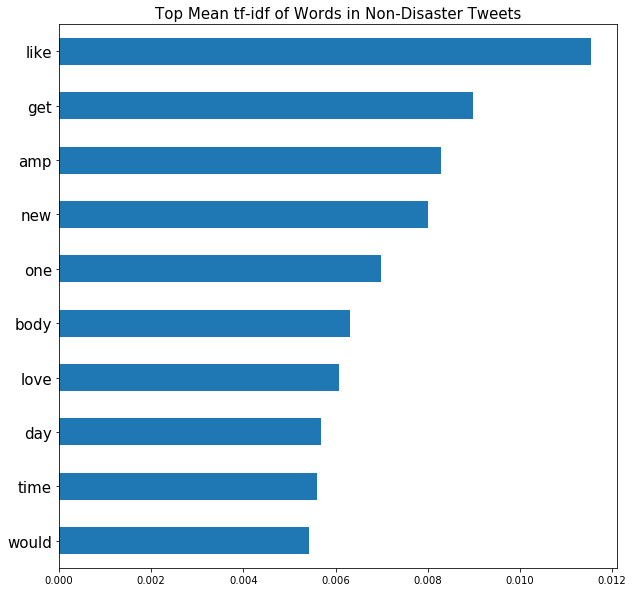

In [22]:
tfidf_vis.loc[tfidf_vis['target_y']==0].drop(columns = 'target_y').mean().sort_values(ascending= True).tail(10).plot(kind = 'barh', figsize = (10,10));
plt.yticks(fontsize = 15);
plt.xticks(fontsize = 10);
plt.title('Top Mean tf-idf of Words in Non-Disaster Tweets', fontsize = 15);

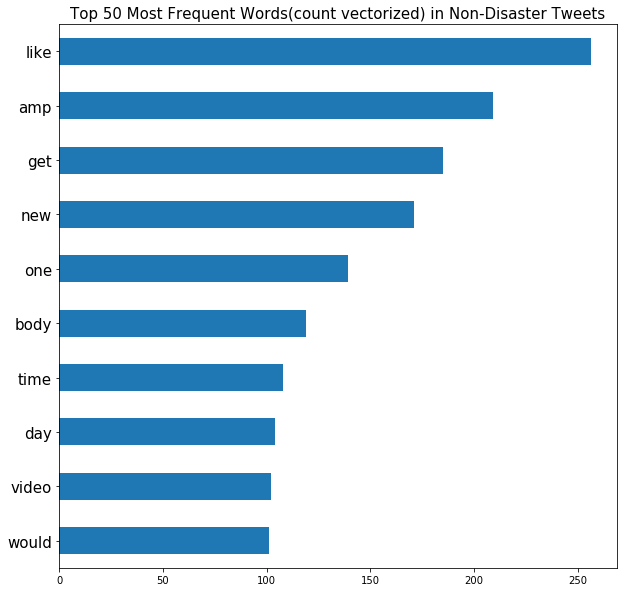

In [23]:
cvec_vis.loc[cvec_vis['target_y']==0].drop(columns = 'target_y').sum().sort_values(ascending= True).tail(10).plot(kind = 'barh', figsize = (10,10));
plt.yticks(fontsize = 15);
plt.xticks(fontsize = 10);
plt.title('Top 50 Most Frequent Words(count vectorized) in Non-Disaster Tweets', fontsize = 15);

### Modeling and Validation

##### Baseline Models

The baseline model will be the model that always predicts the positive class (Disaster Tweet). The validation scores of the final model will compared to the baseline model to test its performance. The two metrics used will be:<br>
- ***Accuracy:*** this will be a generic measurement of the number of correct predictions over the number of total predictions
    - This score ranges from 0-1 with a desired score being as close to 1 as possible
- ***F1-Score/F measure:*** this will be the prime metric used as it will measure the performance of the model by its _precision_($\frac{true positives}{predicted positives}$)<br> but also by its _recall or sensitivity_($\frac{True Positives}{All Positives (both true and false)}$)<br>
    - $F measure = \frac{2 * precision * recall}{precision + recall}$
    - The f1-score will be able to validate how many tweets the model classifies correctly as well as whether it is able to minimize the false positives in the predictions
    - The ideal f1-score ranges from 0-1 with a desired score being as close to 1 as possible. Having an f1-score of 1 is unrealistic because it would mean that the model was able to achieve 100% precision and recall on an unfamiliar testing dataset.<br>

For a model that is responsible for recognizing tweets pertinent to a disaster, it is important to consider the f1-score depending on the use case. If it is being used on realtime data for the sake of alerts, the model must be accurate and precise enough to err on the side of False positives, rather than false negatives because a significant portion of false negatives could mean that while there are emergencies and disasters occuring, they are not being recognized and may be ignored at the risk of human safety.<br>

The baseline accuracy and f1 scores are calculated and shown below:

In [24]:
# Accuracy for baseline model
baseline_acc = round(df['target'].value_counts(normalize = True)[0],2)
baseline_acc

0.57

In [25]:
# Baseline predictions for model that always predicts the positive class
baseline_preds = y.map({0:1,1:1}) 

# f-measure for baseline model
baseline_f1 = round(f1_score(y, baseline_preds),3)
print(f'baseline f measure: {baseline_f1}')

baseline f measure: 0.601


##### Modelling Gridsearch

In order to decide which model would be the best, a gridsearch will be run using the default parameters of 3 types of models:
- *a support vector machine for classification*
    - Text data is typically linearly separable especially with a dataset like this which has been hand classified between the positive and negative class. Therefore, the initial gridsearch can use a linear kernel despite having high dimensionality in the dataset. Using a linear kernel is also faster than using other kernels to map the data to a higher dimension such as `rbf` or `sigmoid`. However, due to the large number of features in this dataset, using a more robust kernel to create the decision boundary may be helpful to increase the accuracy and f measure of the final model. 
- *a random forest classification model*
    - This classification model will learn from multiple decision trees and make a final classification based on the majority vote of the trees, randomly sampling which features to use at each node.
    - This is a useful model to run because the aggregated bootstrap (bagging) used in subsampling the data set as well as the random selection of features at each node reduces overfitting of the model by reducing the correlation of the features used to make predictions. 
- *an adaboost classification model:* 
    - While a random forest model typically yields higher accuracy scores, the adaptive boosting method is better for higher dimensional data with a large number of features. This model will be ran as well to be compared with the other two. 

In [26]:
# Instantiating Pipelines for potential models
pipe_rf_cvec = Pipeline([('cvec',CountVectorizer()),                         
                         ('rf', RandomForestClassifier(n_estimators= 100,
                                                       random_state = 42))])
pipe_rf_tfidf = Pipeline([('tfidf', TfidfVectorizer()),                          
                          ('rf', RandomForestClassifier(n_estimators=100,
                                                        random_state = 42))])
pipe_ada_cvec = Pipeline([('cvec', CountVectorizer()),                          
                          ('ada', AdaBoostClassifier(n_estimators=100,
                                                     random_state = 42))])
pipe_ada_tfidf = Pipeline([('tfidf', TfidfVectorizer()),                           
                           ('ada', AdaBoostClassifier(n_estimators = 100,
                                                      random_state = 42))])
pipe_svc_cvec = Pipeline([('cvec', CountVectorizer()),
                           ('svc', SVC(kernel = 'linear',
                                       gamma = 'scale',
                                       random_state = 42))])
pipe_svc_tfidf = Pipeline([('tfidf', TfidfVectorizer()),                    
                           ('svc', SVC(kernel = 'linear',
                                       gamma = 'scale',
                                       random_state = 42))])
# Instantiating vectorizer parameters
cvec_params = {'cvec__stop_words':[None,'english'],
               'cvec__ngram_range':[(1,1),(1,2),(1,3)]}
tfidf_params = {'tfidf__stop_words': [None, 'english'],
                'tfidf__ngram_range': [(1,1),(1,2),(1,3)]}

# Random Forest GridSearches
grid_rf_cvec = GridSearchCV(pipe_rf_cvec, cvec_params,cv = 5)
grid_rf_tfidf = GridSearchCV(pipe_rf_tfidf, tfidf_params, cv = 5)


# Adaboost GridSearches
grid_ada_cvec = GridSearchCV(pipe_ada_cvec, cvec_params, cv = 5)
grid_ada_tfidf = GridSearchCV(pipe_ada_tfidf, tfidf_params, cv = 5)

# SVC GridSearch
grid_svc_cvec = GridSearchCV(pipe_svc_cvec,cvec_params, cv = 5)
grid_svc_tfidf = GridSearchCV(pipe_svc_tfidf, tfidf_params, cv = 5)

##### Gridsearch and Validation Function

In [27]:
# Function used to run specified models and print out validation metrics
def run_model(models, model_names, predictions):
    # loops through each gridsearch and prints out accuracy scores and parameters for the best estimator
    for (model, model_name, pred) in zip(models, model_names, predictions):
        model.fit(X_train,y_train)
        pred = model.best_estimator_.predict(X_test)
        
        # calculates confusion matrix metrics for each model specifically
        tn,fp,fn,tp = confusion_matrix(y_test, pred).ravel()
        sens = tp/(tp+fn)
        spec = tn/(tn+fp)
        acc = (tp+tn)/(tn+tp+fp+fn)
        precision = tp/(tp+fp)
        false_pos_rate = fn/(tp+fn)
        
        # calculates model-specific f1 score
        f_measure = f1_score(y_test, pred)
        
        # Prints out best parameter combinations as well as validation metrics 
        # Note that while not all of the confusion matrix metrics are printed, they can be added here if need be.
        print(f'{model_name}')
        print(f'best params: {model.best_params_}')
        print(f'best estimator train accuracy: {model.best_estimator_.score(X_train,y_train)}')
        print(f'best estimator test accuracy: {model.best_estimator_.score(X_test,y_test)}')
    
        print(f'sensitivity: {sens}, specificity: {spec}, precision: {precision}')
   
        print(f'f1_score: {f_measure}')
        print()
    # Pre-defined baseline metrics
    print(f'baseline accuracy:{baseline_acc}')
    print(f'baseline f measure: {baseline_f1}')

In [28]:
models = [grid_rf_cvec, grid_rf_tfidf, grid_ada_cvec, 
          grid_ada_tfidf, grid_svc_cvec, grid_svc_tfidf]
model_names = ['CountVectorized Random Forest','TFIDF Random Forest',
               'CountVectorized Adaboost','TFIDF Adaboost', 'CountVectorized SVM for Class', 'TFIDF SVM for CLass']
predictions = ['cvec_rf_pred', 'tfidf_rf_pred', 'cvec_adaboost_pred', 'tfidf_adaboost_pred',
               'cvec_svc_pred', 'tfidf_svc_pred'] 
run_model(models, model_names, predictions)

CountVectorized Random Forest
best params: {'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}
best estimator train accuracy: 0.9886144683832545
best estimator test accuracy: 0.7977941176470589
sensitivity: 0.6699266503667481, specificity: 0.8941068139963168, precision: 0.8265460030165912
f1_score: 0.7400405131667792

TFIDF Random Forest
best params: {'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
best estimator train accuracy: 0.9887896304081275
best estimator test accuracy: 0.7972689075630253
sensitivity: 0.6723716381418093, specificity: 0.8913443830570903, precision: 0.8233532934131736
f1_score: 0.740242261103634

CountVectorized Adaboost
best params: {'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
best estimator train accuracy: 0.7880539499036608
best estimator test accuracy: 0.7725840336134454
sensitivity: 0.6625916870415648, specificity: 0.8554327808471455, precision: 0.7753934191702432
f1_score: 0.7145682267633487

TFIDF Adaboost
best params: {'tfidf__

Based on the gridsearch, all models were able to outperform the baseline model's accuracy and f measure with the default hyperparameter.<br>
The support vector machine for classification with the tfidf vectorized dataset yielded the highest training and testing accuracy scores with the lowest variance between the two scores.
Therefore, the best model to be used is the TfidfVectorized SVM for classification. However, now that the ideal model has been selected, hyperparameters such as the kernel used and the regularization strength must be tuned.

In [29]:
pipe_svc_tfidf = Pipeline([('tfidf', TfidfVectorizer()),                    
                           ('svc', SVC(gamma = 'scale',
                                       random_state = 42))])

tfidf_params = {'tfidf__stop_words': [None],   # used no additional stop words list because the stopwords from the initial text cleaning was deemed best in previous gridsearch
                'tfidf__ngram_range': [(1,2)], # used the best ngram range in previous model for optimized speed of gridsearch
                'svc__C': [1,.1,.01,.001],
                'svc__kernel': ['linear','rbf']}

grid_svc_tfidf = GridSearchCV(pipe_svc_tfidf, tfidf_params, cv = 5)

run_model([grid_svc_tfidf], ['tf-idf vectorized Support Vector Machine'], ['tfidf_svc_preds'])

tf-idf vectorized Support Vector Machine
best params: {'svc__C': 1, 'svc__kernel': 'linear', 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
best estimator train accuracy: 0.9696969696969697
best estimator test accuracy: 0.8140756302521008
sensitivity: 0.7408312958435208, specificity: 0.8692449355432781, precision: 0.8101604278074866
f1_score: 0.7739463601532568

baseline accuracy:0.57
baseline f measure: 0.601


## Conclusions and Next Steps

The best performing model out of all the ones tested ended up being the tfidf vectorized support vector machine for classification with a (1,2) ngram range, regularization parameter of 1, and a linear kernel which makes sense because of the linear separability of tfidf vectorized text data. 

This model is a relatively simple one. Even with the default parameters and basic modeling techniques, the model was able to classify over 80% of the tweets in the testing corpus correctly. Using more updated machine learning techniques such as recurrent neural networks or even another type of vectorizer such as a word2vec or doc2vec model, the model accuracy and sensitivity could be optimized significantly. Social media is a tedious source of data to be able to scrape useful information from. The data acquired for this notebook was graciously orgainized and hand classified by the company [Figure-Eight](https://www.figure-eight.com/data-for-everyone/). However, with advancements in technology and the quickly increasing availability of data, social media is becoming a more and more accessible source for data that can be used in numerous applications beneficial to society. This model that is able to distinguish between disaster related and non-disaster related tweets could be used to map the occurence of road closures, and natural disasters if location data was more readily available in order to map evacuation routes even when satellite imaging is not able to get accurate and updated information. Next steps to improving this model would be to read and infer locations using the text information in the tweets and possibly develop a map using latitude and longitude coordinates derived from these inferences. 